# MCMC

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jn
from  matplotlib import pyplot as plt
import jax
from jax import random

from src.utils import l2sq
from src.algorithm import*

plt.rcParams["figure.figsize"]=8,8

[[ 5.04190711  0.52059493 -0.21496908 ... -0.40791694  0.42577778
   0.15122165]
 [ 0.52059493  5.47892409  0.39699437 ... -0.46599723  0.50818517
  -0.14228438]
 [-0.21496908  0.39699437  5.18511259 ... -0.07583597 -0.09852958
   0.18699629]
 ...
 [-0.40791694 -0.46599723 -0.07583597 ...  5.24166146 -0.18856105
   0.16585698]
 [ 0.42577778  0.50818517 -0.09852958 ... -0.18856105  4.754806
  -0.27071776]
 [ 0.15122165 -0.14228438  0.18699629 ...  0.16585698 -0.27071776
   4.80673926]]


(-12.0, 12.0)

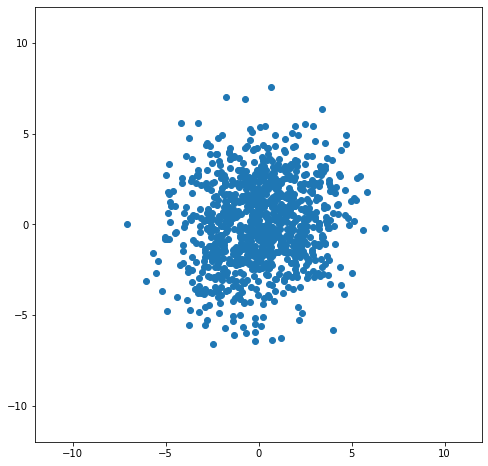

In [36]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

k = 100
M = jnp.zeros(k)
#c = jnp.array([[1,0],[0,10]])
#c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,))*10)
D= d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1/jnp.diag(D)) @ Q
print(C)

S = random.multivariate_normal(sk[2], M, C, (1000,))
plt.scatter(S[:,0], S[:,1])
plt.xlim(-12,12)
plt.ylim(-12,12)

(-12.0, 12.0)

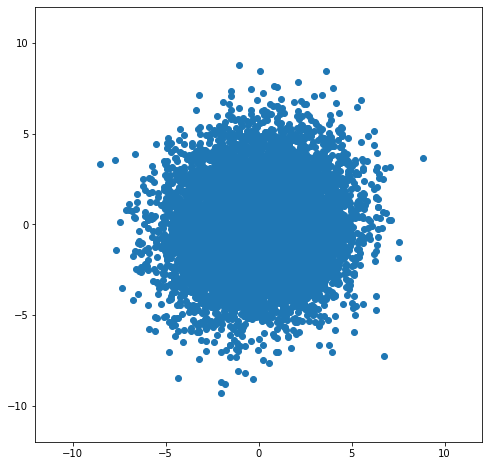

In [37]:
S = random.multivariate_normal(sk[2], M, C, (10000,))
plt.scatter(S[:,0], S[:,1])
plt.xlim(-12,12)
plt.ylim(-12,12)

In [39]:
def plot_mcmc_samples(samples, r, x0, M, C):

    plt.rcParams["figure.figsize"]=16,8

    plt.subplot(1,2,1)
    plt.plot(x0[0], x0[1], 'ro')
    plt.scatter(samples[:,0], samples[:,1])
    plt.xlim(-20,20)
    plt.ylim(-20,20)

    plt.subplot(1,2,2)
    plt.plot(r)

    plt.rcParams["figure.figsize"]=8,8

    M_est = jnp.mean(samples, axis = 0)
    print("Mean error =", jnp.linalg.norm(M - M_est))

    C_est = jnp.cov(samples.transpose())
    print("Covariance error =", jnp.linalg.norm(C - C_est)/jnp.linalg.norm(C))

In [40]:
logPi = lambda x : -1/2 * (x-M) @ C_inv @ (x-M) - jnp.log(jnp.sqrt((2*jnp.pi)**k * jnp.linalg.det(C)))
gradLogPi = jax.grad(logPi)

pi = lambda x : jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

In [41]:
#logPi(jnp.array([10,20]))
#gradLogPi(jnp.array([0.,-5.]))

In [42]:
#x = jnp.arange(-20,20)
#y = [pi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y)
#plt.show
#y2 = [pi(jnp.array([xi,0])) for xi in x]
#plt.plot(x,y2)
#plt.show()
#y3 = [logPi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y3)

#gradLogPi(jnp.array([0.,-5.]))

In [43]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
print(key)

[0 1]


In [44]:
print(key)
key, sk1, sk2 = random.split(key,3)
print(key)
#print(random.normal(key))

print(sk1)
print(sk2)
#print(random.normal(subkey))


[0 1]
[3568232559  713140391]
[3620866055 2761185182]
[2442350529 2639019713]


### MALA

In [45]:
x0 = jnp.array(np.random.randn(k))
tau = 0.01
N = 10000

key, *keys = random.split(key, 2*N+1)

In [46]:
samples_mala = []
samples_mala.append(x0)
r_mala = []
r_mala.append(1)
x1c = x0

t0 = time.time()
for i in jnp.arange(1, N):
    if jnp.mod(i, 100) == 0:
        print(i)
        
    x1p = x1c
    x1c, r = mala_proposal(keys[2*i], logPi, gradLogPi, samples_mala[i-1], tau)
    a = jnp.minimum(1, r)
    r_mala.append(a)
    
    x1c = jax.lax.cond(random.uniform(keys[2*i+1]) < a,
        true_fun = lambda _ : x1c,
        false_fun = lambda _ : x1p,
        operand = None)
    
    samples_mala.append(x1c)
        
print("Time ", time.time()-t0)

samples_mala = jnp.array(samples_mala)
r_mala = jnp.array(r_mala)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
Time  110.19462490081787


Mean error = 10.505237708450622
Covariance error = 0.9928260887640848


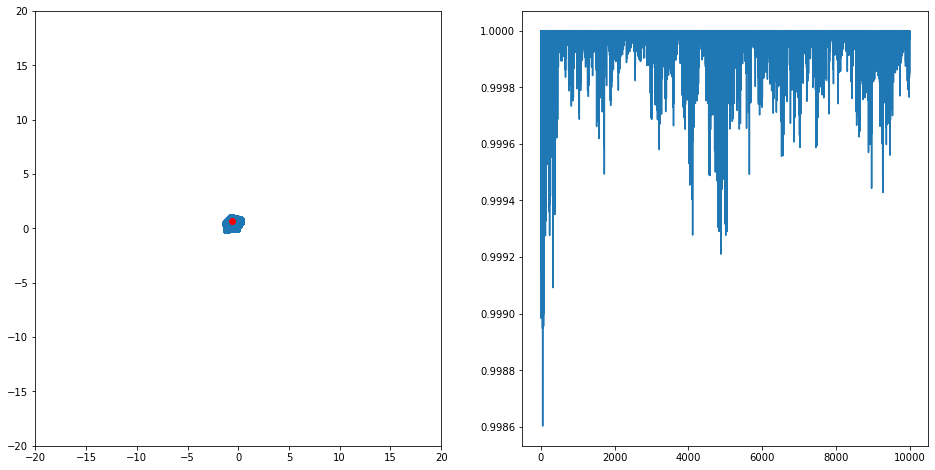

In [47]:
plot_mcmc_samples(samples_mala, r_mala, x0, M, C)

### HMC

In [57]:
dt = 0.05
L = 30
N = 10000

key, *keys = random.split(key, 2*N+1)

In [58]:
samples_hmc = []
samples_hmc.append(x0)
r_hmc = []
r_hmc.append(1)
x1c = x0

t0 = time.time()
for i in range(1, N):
    if jnp.mod(i, 100) == 0:
        print(i)
        
    x1c, r = hmc_proposal(keys[i], logPi, gradLogPi, samples_hmc[i-1], dt, L)
    a = jnp.minimum(1, r)
    r_hmc.append(a)
    
    x1c = jax.lax.cond(random.uniform(keys[2*i+1]) < a,
        true_fun = lambda _ : x1c,
        false_fun = lambda _ : x1p,
        operand = None)
    
    samples_hmc.append(x1c)
    
print("Time ", time.time()-t0)
    
samples_hmc = jnp.array(samples_hmc)
r_hmc = jnp.array(r_hmc)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
Time  127.72461605072021


Mean error = 0.7590859476682087
Covariance error = 0.2045312721542364


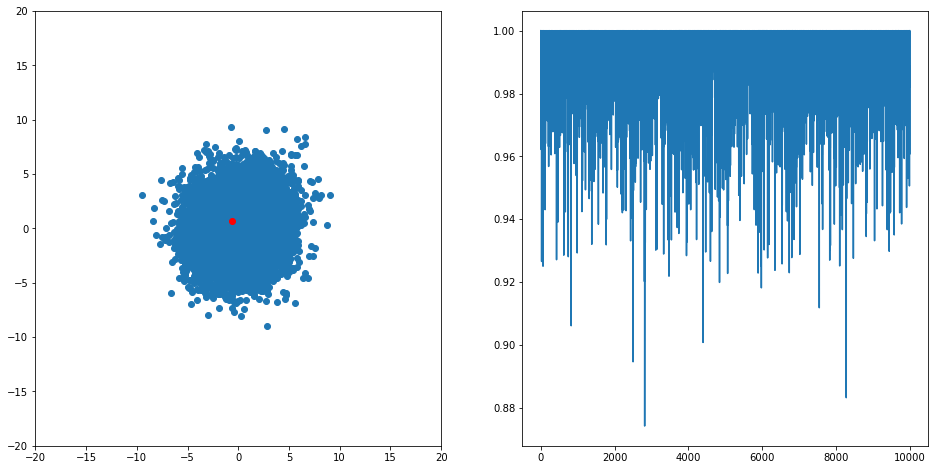

In [59]:
plot_mcmc_samples(samples_hmc, r_hmc, x0, M, C)

In [60]:
def get_norm_conv(samples, M, C):
    norm_m = []
    norm_c = []
    for i in range(10,N):
        if jnp.mod(i,100) == 0:
            Merr = jnp.linalg.norm(jnp.mean(samples[:i], axis = 0) - M)
            Cerr = jnp.linalg.norm(jnp.cov(samples[:i].transpose()) - C)/jnp.linalg.norm(C)
            norm_m.append(Merr)
            norm_c.append(Cerr)

    norm_m = jnp.array(norm_m)
    norm_c = jnp.array(norm_c)
    return norm_m, norm_c

In [61]:
norm_m_hmc, norm_c_hmc = get_norm_conv(samples_hmc, M, C)

In [62]:
norm_m_mala, norm_c_mala = get_norm_conv(samples_mala, M, C)

In [63]:
xx = []
for i in range(10,N):
    if jnp.mod(i, 100) == 0:
        xx.append(i)
xx = jnp.array(xx)
yy = 1/jnp.sqrt(xx)

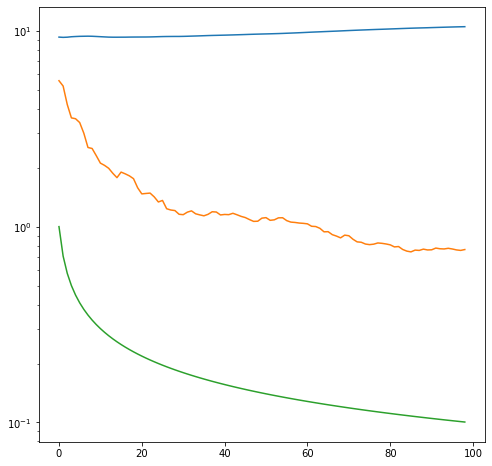

In [66]:
plt.semilogy(norm_m_mala)
plt.semilogy(norm_m_hmc)
plt.semilogy(yy*10)

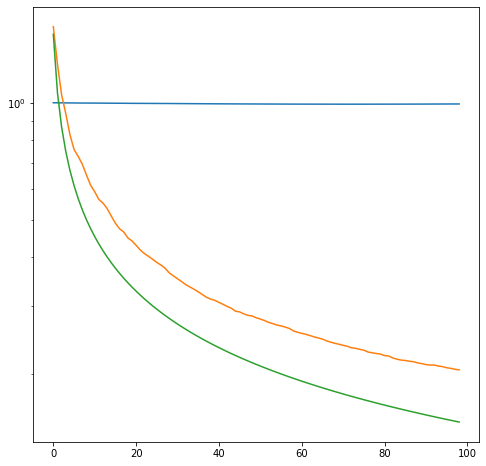

In [65]:
plt.semilogy(norm_c_mala)
plt.semilogy(norm_c_hmc)
plt.semilogy(yy*15)